# Third model: TFIDF + complexity features

In [2]:
import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

In [ ]:
!pip install xgboost

    98% |███████████████████████████████▌| 112.3MB 4.6MB/s eta 0:00:011

In [18]:
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import gc

ModuleNotFoundError: No module named 'xgboost'

In [4]:
df = pd.read_csv('~/TFM_fake_news_detector/data/corpus_features.csv', index_col = 0)

In [5]:
y = df['Category']

In [6]:
df_index = df.index

## TfidfVectorizer

The TfidfVectorizer serves us to convert a collection of raw documents into a matrix of TF and IDF features.

### IDF (Inverse Document Frequency)

The IDF is used to calculate how many times a word appears on a set of documents.

### TF (Term Frequency)

The TF, unlike the IDF is the number of times a word appears in a single document.

## Spanish tokenization

    - Spanish stopwords
    - Added more spanish punctuation
    - Created stems with lemmas, using the rooting word

In [7]:
#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

In [8]:
#Spanish stemmer: Stemming is the process to transform any word into its rooting word, considering them as the same word
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [9]:
#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

In [10]:
def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## TFIDF Vectorizer transformation with the tokenization explaned

In [11]:
tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

### Transformation

In [12]:
text_vectorized = tfidf_vectorizer.fit_transform(df['Text']) 

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
tfvocab = tfidf_vectorizer.get_feature_names()

### Make Dense dataframe Sparse, and Combine with TF-IDF features

In [14]:
categorical_features = ['sentences', 'n_words', 'avg_words_sent', 'avg_word_size', 'TTR']

X = hstack([csr_matrix(df[categorical_features].values), text_vectorized[0:]])
tfvocab = df.columns.tolist() + tfvocab

for shape in [X]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
gc.collect();

971 Rows and 15569 Cols
Feature Names Length:  15576


In [201]:
# X = hstack([
#     text_vectorized,
#     csr_matrix(df[categorical_features].loc[df_index,].values)], 'csr'
# )
# print("train shape: {} rows, {}".format(*X.shape))

### Split in training and test for validation

In [15]:
# Training and Validation Set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 23)

## Model: XGB

In [17]:
xgb_params = {'eta': 0.05, 
              'max_depth': 12, 
              'subsample': 0.8, 
              'colsample_bytree': 0.75,
              #'min_child_weight' : 1.5,
              'scale_pos_weight': imbalance_weight,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 23,
              'lambda': 1.5,
              'alpha': .6
             }

NameError: name 'imbalance_weight' is not defined

In [16]:
pa_classifier = PassiveAggressiveClassifier(max_iter=50)
pa_classifier.fit(X_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

## Predictions & results

In [71]:
y_pred = pa_classifier.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

Accuracy: 57.53%


In [72]:
cf_matrix = confusion_matrix(y_test,y_pred, labels = ['Fake','True'])
print(cf_matrix)

[[ 24 116]
 [  8 144]]


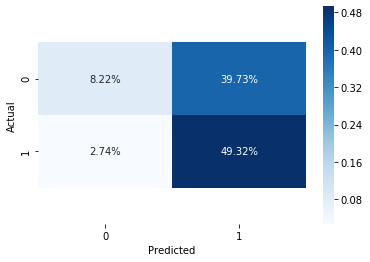

In [73]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()